<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Import Libraries </span>

In [1]:
import python_utils.common_utils as cu
import missingno as msn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl 
import numpy as np
import os 
import warnings
%run ../visualizations/plottings.ipynb
warnings.filterwarnings('ignore')

<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Load Dataset </span>

In [2]:
df = cu.load_df("parquet", "pd", "../../dataset/raw/ozone_hourly_2014.parquet")
df.head()


,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Date Local,...,Units of Measure,MDL,Uncertainty,Qualifier,Method Type,Method Code,Method Name,State Name,County Name,Date of Last Change
0,01,003,0010,44201,1,30.497478,-87.880258,NAD83,Ozone,2014-03-01,...,Parts per million,0.005,NaN,None,FEM,47,INSTRUMENTAL - ULTRA VIOLET,Alabama,Baldwin,2014-06-30
1,01,003,0010,44201,1,30.497478,-87.880258,NAD83,Ozone,2014-03-01,...,Parts per million,0.005,NaN,None,FEM,47,INSTRUMENTAL - ULTRA VIOLET,Alabama,Baldwin,2014-06-30
2,01,003,0010,44201,1,30.497478,-87.880258,NAD83,Ozone,2014-03-01,...,Parts per million,0.005,NaN,None,FEM,47,INSTRUMENTAL - ULTRA VIOLET,Alabama,Baldwin,2014-06-30
3,01,003,0010,44201,1,30.497478,-87.880258,NAD83,Ozone,2014-03-01,...,Parts per million,0.005,NaN,None,FEM,47,INSTRUMENTAL - ULTRA VIOLET,Alabama,Baldwin,2014-06-30
4,01,003,0010,44201,1,30.497478,-87.880258,NAD83,Ozone,2014-03-01,...,Parts per million,0.005,NaN,None,FEM,47,INSTRUMENTAL - ULTRA VIOLET,Alabama,Baldwin,2014-06-30


<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Convert Data Types </span>

In [3]:
d_type = {'State Code': str, 'County Code': str, 'Site Num': str, 'Parameter Code': str, 'POC': int,
       'Latitude': float, 'Longitude': float, 'Datum': str, 'Parameter Name': str, 'Date Local': str,
       'Time Local': str, 'Date GMT': str, 'Time GMT': str, 'Sample Measurement': float,
       'Units of Measure': str, 'MDL': float, 'Uncertainty': float, 'Qualifier': str, 'Method Type': str,
       'Method Code': int, 'Method Name': str, 'State Name': str, 'County Name': str,'Date of Last Change': str}

df = df.astype(d_type)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9060694 entries, 0 to 9060693
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   State Code           object 
 1   County Code          object 
 2   Site Num             object 
 3   Parameter Code       object 
 4   POC                  int32  
 5   Latitude             float64
 6   Longitude            float64
 7   Datum                object 
 8   Parameter Name       object 
 9   Date Local           object 
 10  Time Local           object 
 11  Date GMT             object 
 12  Time GMT             object 
 13  Sample Measurement   float64
 14  Units of Measure     object 
 15  MDL                  float64
 16  Uncertainty          float64
 17  Qualifier            object 
 18  Method Type          object 
 19  Method Code          int32  
 20  Method Name          object 
 21  State Name           object 
 22  County Name          object 
 23  Date of Last Change  object 
dty

<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Make column names more consistent </span>

In [4]:
df.columns


Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change'],
      dtype='object')

In [5]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.columns


Index(['state_code', 'county_code', 'site_num', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter_name', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'mdl', 'uncertainty', 'qualifier', 'method_type',
       'method_code', 'method_name', 'state_name', 'county_name',
       'date_of_last_change'],
      dtype='object')

<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Detect & Handle Outliers </span>

In [6]:
numeric_columns = df.select_dtypes('number').columns
numeric_columns


Index(['poc', 'latitude', 'longitude', 'sample_measurement', 'mdl',
       'uncertainty', 'method_code'],
      dtype='object')

In [7]:
df_sub = df.loc[:, numeric_columns]
df_sub.head()


,poc,latitude,longitude,sample_measurement,mdl,uncertainty,method_code
0,1,30.497478,-87.880258,0.047,0.005,NaN,47
1,1,30.497478,-87.880258,0.047,0.005,NaN,47
2,1,30.497478,-87.880258,0.043,0.005,NaN,47
3,1,30.497478,-87.880258,0.038,0.005,NaN,47
4,1,30.497478,-87.880258,0.035,0.005,NaN,47


In [8]:
df_sub.describe()


,poc,latitude,longitude,sample_measurement,mdl,uncertainty,method_code
count,9.060694e+06,9.060694e+06,9.060694e+06,9.060694e+06,9.060694e+06,0.0,9.060694e+06
mean,1.070256e+00,3.743710e+01,-9.534912e+01,3.027292e-02,1.360743e-01,NaN,7.107903e+01
std,3.276548e-01,5.048730e+00,1.632385e+01,1.550847e-02,8.123390e-01,NaN,4.324711e+01
min,1.000000e+00,1.817794e+01,-1.580886e+02,-5.000000e-03,6.000000e-04,NaN,1.900000e+01
25%,1.000000e+00,3.391814e+01,-1.099068e+02,1.900000e-02,5.000000e-03,NaN,4.700000e+01
50%,1.000000e+00,3.801333e+01,-9.200632e+01,3.000000e-02,5.000000e-03,NaN,8.700000e+01
75%,1.000000e+00,4.092200e+01,-8.197222e+01,4.100000e-02,5.000000e-03,NaN,8.700000e+01
max,6.000000e+00,6.484569e+01,-6.591548e+01,2.130000e-01,8.000000e+00,NaN,9.010000e+02


In [9]:
df_sub['poc'].unique()


array([1, 2, 6, 3, 4])

In [10]:
df_sub['method_code'].unique()


array([ 47,  87,  56,  19, 199,  91, 190, 901, 187,  53, 160, 112])

In [11]:
df_sub['mdl'].unique()


array([5.0e-03, 5.0e+00, 6.0e-04, 3.0e-03, 8.0e+00, 1.5e-03])

In [12]:
df_sub['sample_measurement'].unique()


array([ 0.047,  0.043,  0.038,  0.035,  0.034,  0.037,  0.044,  0.046,
        0.045,  0.042,  0.039,  0.033,  0.031,  0.029,  0.023,  0.026,
        0.025,  0.027,  0.04 ,  0.041,  0.036,  0.028,  0.013,  0.014,
        0.017,  0.021,  0.032,  0.03 ,  0.02 ,  0.019,  0.018,  0.016,
        0.015,  0.012,  0.011,  0.022,  0.024,  0.003,  0.002,  0.   ,
        0.006,  0.053,  0.057,  0.054,  0.052,  0.048,  0.051,  0.049,
        0.008,  0.009,  0.005,  0.004,  0.055,  0.01 ,  0.007,  0.056,
        0.05 ,  0.061,  0.059,  0.06 ,  0.058,  0.001,  0.066,  0.065,
        0.064,  0.067,  0.069,  0.063,  0.074,  0.073,  0.071,  0.076,
        0.078,  0.077,  0.07 ,  0.068,  0.062,  0.075,  0.072,  0.081,
        0.123,  0.082,  0.079, -0.001,  0.085,  0.084,  0.086,  0.083,
        0.08 ,  0.091,  0.096,  0.093,  0.087,  0.088,  0.092,  0.09 ,
        0.094,  0.095,  0.089,  0.102,  0.099,  0.098,  0.097,  0.105,
        0.106,  0.104,  0.116, -0.002,  0.103,  0.101,  0.11 ,  0.107,
      

In [13]:
df_sub.drop(
    labels=['latitude','longitude','poc','method_code','method_code', 'mdl', 'uncertainty'], axis=1, inplace=True
)
df_sub


,sample_measurement
0,0.047
1,0.047
2,0.043
3,0.038
4,0.035
...,...
9060689,0.019
9060690,0.021
9060691,0.024
9060692,0.002


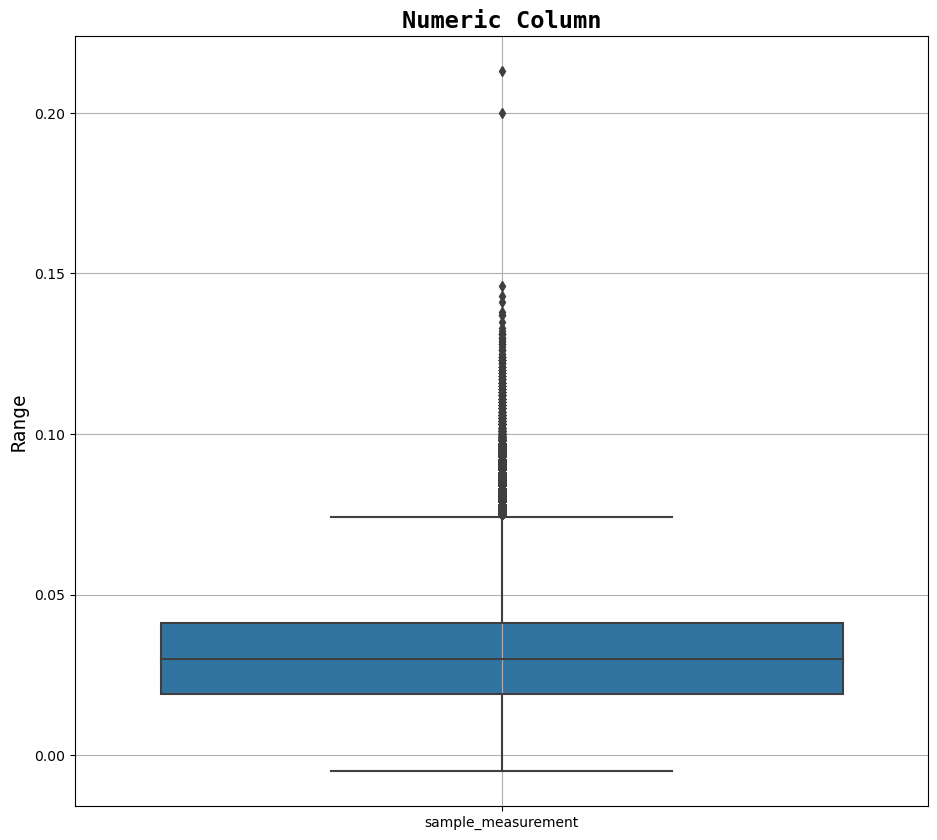

In [14]:
plot_boxplot(df_sub, ["Numeric Column", "", "Range"])


In [15]:
numeric_columns = df_sub.select_dtypes('number').columns
lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3
df.loc[:, numeric_columns] = df_sub.where(lim, np.nan)
df['sample_measurement'].head(15)


0     0.047
1     0.047
2     0.043
3     0.038
4     0.035
5     0.035
6     0.034
7     0.037
8     0.044
9     0.046
10    0.046
11    0.046
12    0.046
13    0.046
14    0.045
Name: sample_measurement, dtype: float64

<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Truncate Missing/NaN Values </span>

In [16]:
df.shape


(9060694, 24)

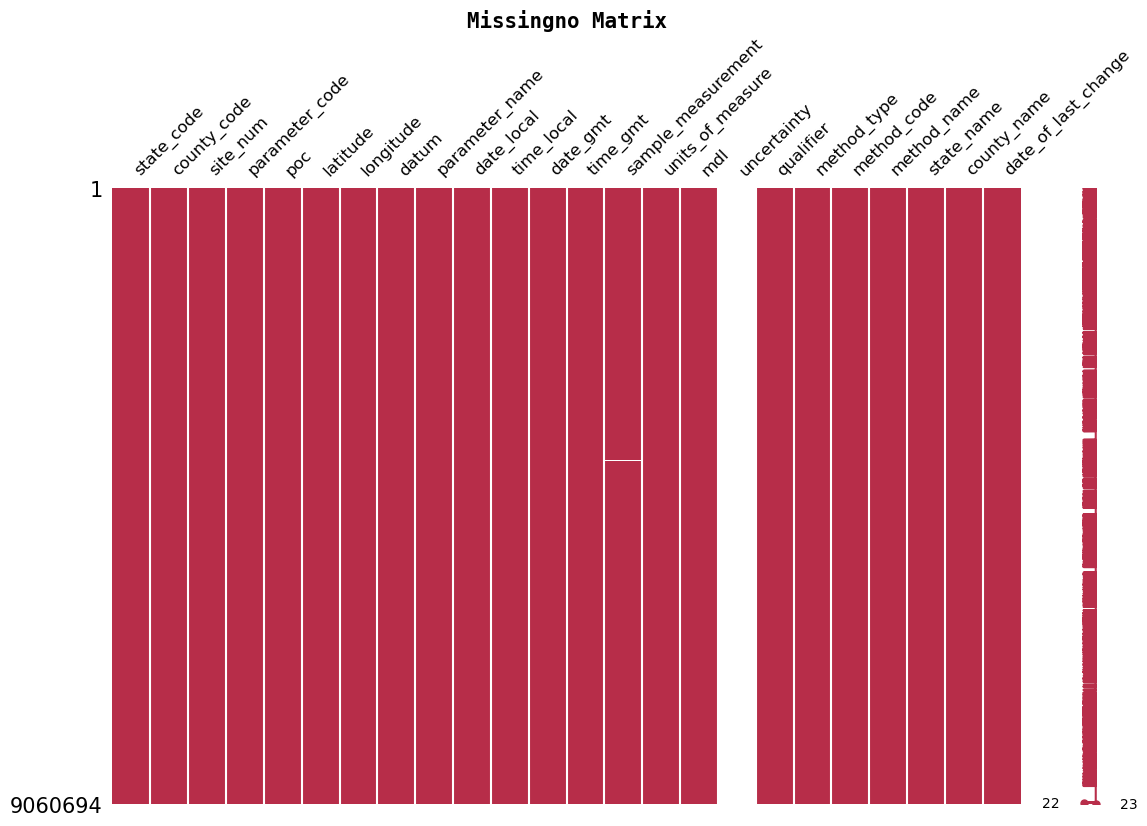

In [17]:
plot_missing_no(df, "Missingno Matrix")


In [18]:
df.isnull().sum()


state_code                   0
county_code                  0
site_num                     0
parameter_code               0
poc                          0
latitude                     0
longitude                    0
datum                        0
parameter_name               0
date_local                   0
time_local                   0
date_gmt                     0
time_gmt                     0
sample_measurement       22777
units_of_measure             0
mdl                          0
uncertainty            9060694
qualifier                    0
method_type                  0
method_code                  0
method_name                  0
state_name                   0
county_name                  0
date_of_last_change          0
dtype: int64

In [19]:
print(f"Uncertainty Null Values\nTotal Rows: {df.shape[0]} \nNull Rows: {df['uncertainty'].isnull().sum()}")


Uncertainty Null Values
Total Rows: 9060694 
Null Rows: 9060694


In [20]:
df.drop(
    labels=['uncertainty'], axis=1, inplace=True
)
df.columns


Index(['state_code', 'county_code', 'site_num', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter_name', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'mdl', 'qualifier', 'method_type', 'method_code',
       'method_name', 'state_name', 'county_name', 'date_of_last_change'],
      dtype='object')

In [21]:
df.dropna(subset=['sample_measurement'], inplace=True)
df.columns


Index(['state_code', 'county_code', 'site_num', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter_name', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'mdl', 'qualifier', 'method_type', 'method_code',
       'method_name', 'state_name', 'county_name', 'date_of_last_change'],
      dtype='object')

In [22]:
df.isnull().sum()


state_code             0
county_code            0
site_num               0
parameter_code         0
poc                    0
latitude               0
longitude              0
datum                  0
parameter_name         0
date_local             0
time_local             0
date_gmt               0
time_gmt               0
sample_measurement     0
units_of_measure       0
mdl                    0
qualifier              0
method_type            0
method_code            0
method_name            0
state_name             0
county_name            0
date_of_last_change    0
dtype: int64

In [23]:
duplicate_cells = 0
duplicate_bool = df.duplicated()

for row in duplicate_bool:
    duplicate_cells += 1 if row else 0

duplicate_prc = (duplicate_cells / len(duplicate_bool)) * 100
print(f"Total Cells: {len(df)}\nDuplicate Cells: {duplicate_cells}\nDuplication %: {duplicate_prc}")



Total Cells: 9037917
Duplicate Cells: 0
Duplication %: 0.0


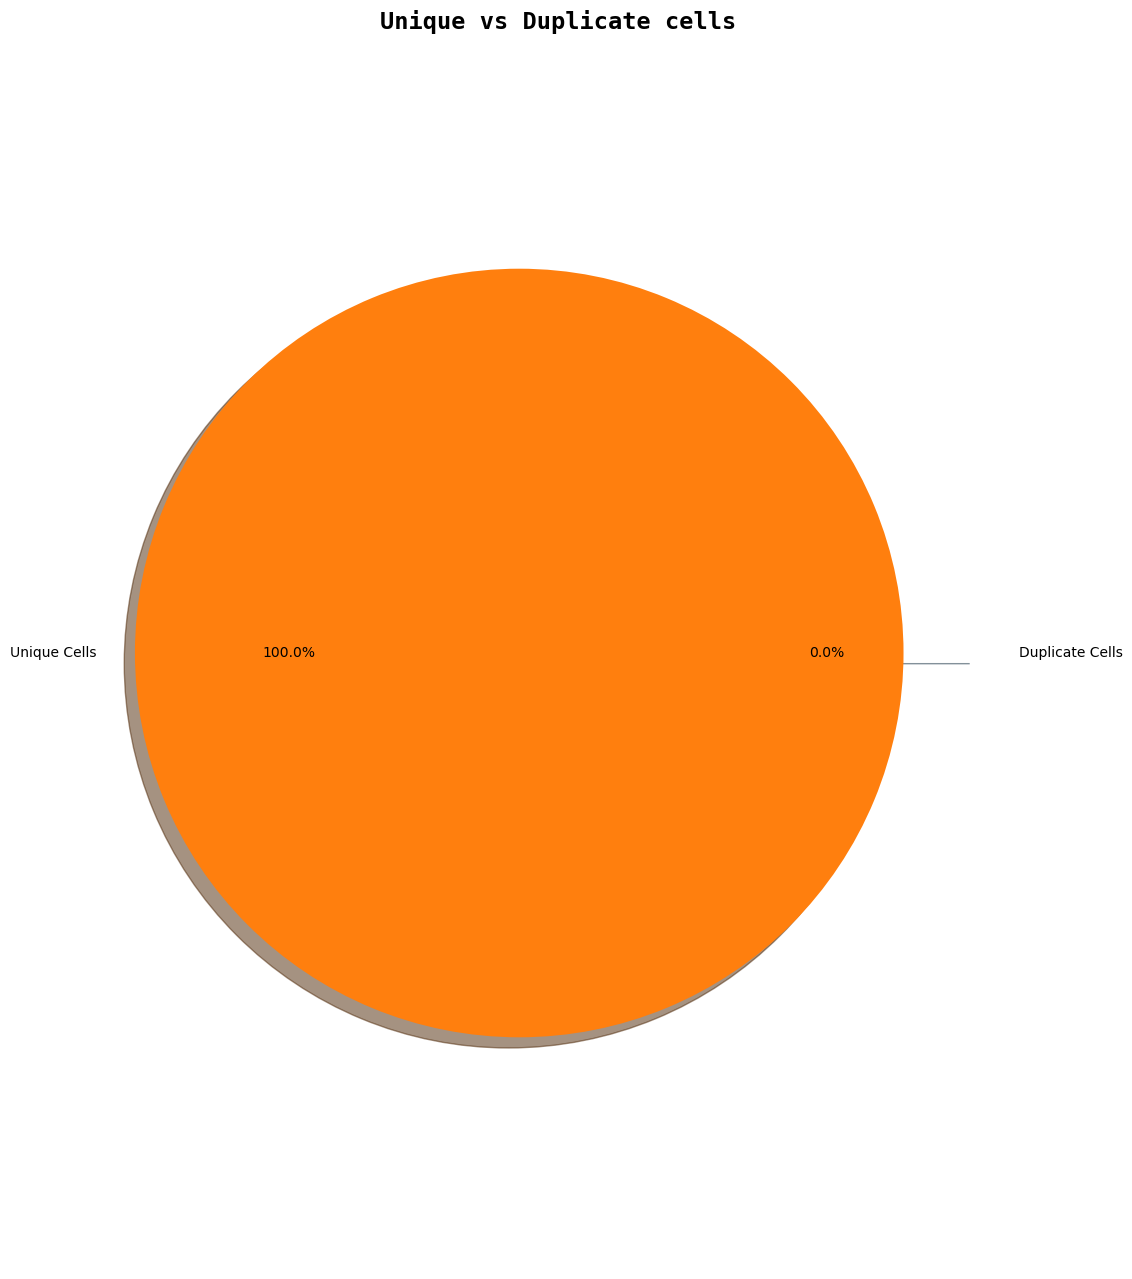

In [32]:
data_values = np.array([duplicate_cells, len(df)-duplicate_cells])
explode = [0.2, 0]
graph_labels = ["Duplicate Cells", "Unique Cells"]
title = "Unique vs Duplicate cells"

plot_pie(data_values, graph_labels, explode=explode, title=title)


<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> Remove Irrelevant data </span>

In [33]:
df.describe()


,poc,latitude,longitude,sample_measurement,mdl,method_code
count,9.037917e+06,9.037917e+06,9.037917e+06,9.037917e+06,9.037917e+06,9.037917e+06
mean,1.070348e+00,3.744119e+01,-9.531016e+01,3.013781e-02,1.348698e-01,7.106337e+01
std,3.279214e-01,5.052288e+00,1.631064e+01,1.528778e-02,8.086479e-01,4.328538e+01
min,1.000000e+00,1.817794e+01,-1.580886e+02,-5.000000e-03,6.000000e-04,1.900000e+01
25%,1.000000e+00,3.391814e+01,-1.098708e+02,1.900000e-02,5.000000e-03,4.700000e+01
50%,1.000000e+00,3.801333e+01,-9.200632e+01,3.000000e-02,5.000000e-03,8.700000e+01
75%,1.000000e+00,4.092458e+01,-8.193926e+01,4.100000e-02,5.000000e-03,8.700000e+01
max,6.000000e+00,6.484569e+01,-6.591548e+01,7.600000e-02,8.000000e+00,9.010000e+02


In [30]:
df.columns

Index(['state_code', 'county_code', 'site_num', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter_name', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'mdl', 'qualifier', 'method_type', 'method_code',
       'method_name', 'state_name', 'county_name', 'date_of_last_change'],
      dtype='object')

In [34]:
df['datum'].unique()


array(['NAD83', 'WGS84'], dtype=object)

In [35]:
df['parameter_code'].unique()


array(['44201'], dtype=object)

In [36]:
df['parameter_name'].unique()


array(['Ozone'], dtype=object)

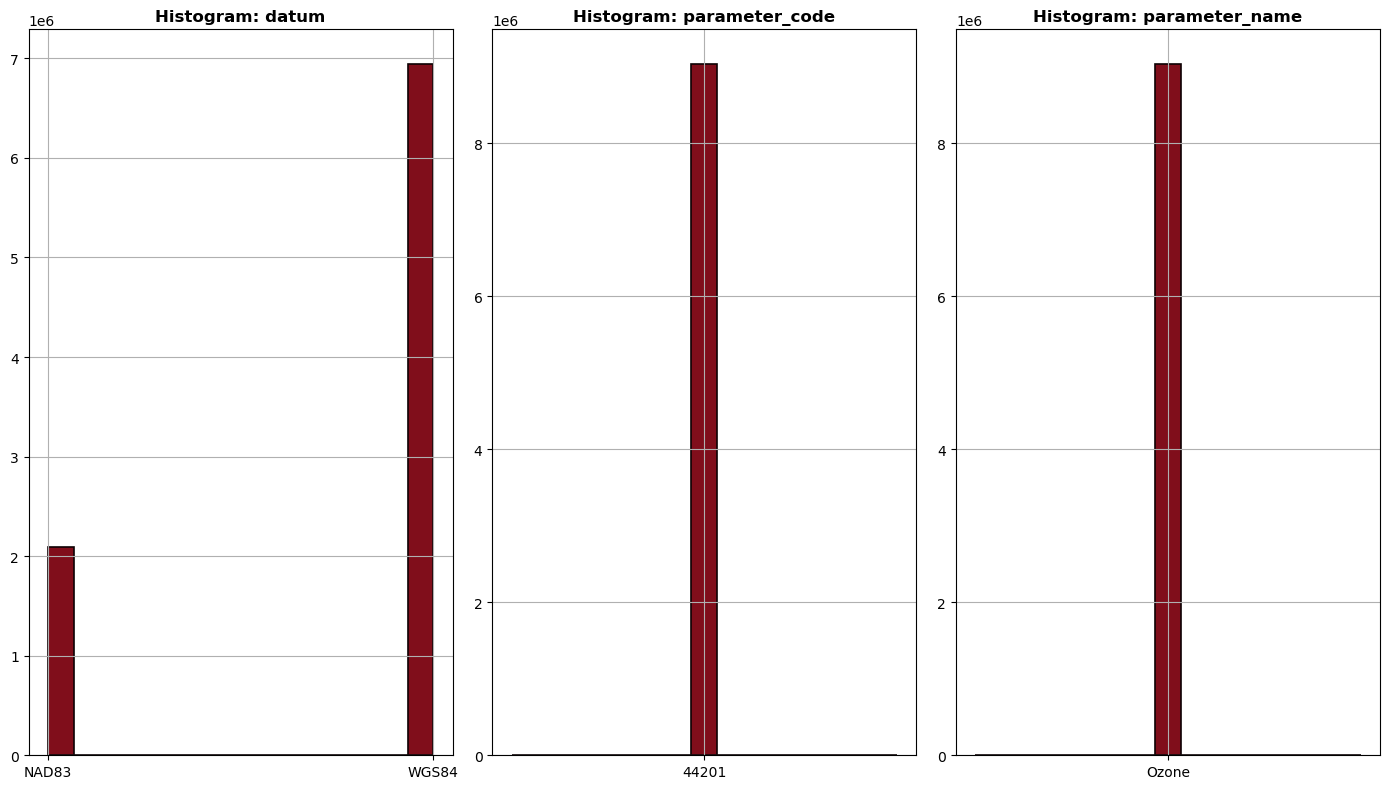

In [37]:
bins = 15
generate_subplots([df['datum'], df['parameter_code'], df['parameter_name']], 15)


In [38]:
df.drop(labels=['site_num', 'parameter_code', 'latitude', 'longitude', 'datum', 'parameter_code', 'parameter_name'], 
        axis=1, inplace=True)
df.columns


Index(['state_code', 'county_code', 'poc', 'date_local', 'time_local',
       'date_gmt', 'time_gmt', 'sample_measurement', 'units_of_measure', 'mdl',
       'qualifier', 'method_type', 'method_code', 'method_name', 'state_name',
       'county_name', 'date_of_last_change'],
      dtype='object')

In [39]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9037917 entries, 0 to 9060693
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   state_code           object 
 1   county_code          object 
 2   poc                  int32  
 3   date_local           object 
 4   time_local           object 
 5   date_gmt             object 
 6   time_gmt             object 
 7   sample_measurement   float64
 8   units_of_measure     object 
 9   mdl                  float64
 10  qualifier            object 
 11  method_type          object 
 12  method_code          int32  
 13  method_name          object 
 14  state_name           object 
 15  county_name          object 
 16  date_of_last_change  object 
dtypes: float64(2), int32(2), object(13)
memory usage: 1.1+ GB


In [40]:
cu.save_df(df, "parquet", "../../dataset/compressed/ozone_hourly_2014.parquet")


In [4]:
def compare_file_size(raw_parquet, compressed_parquet, raw_csv):
    byte_to_mb = 1/(10**6)
    raw_parquet_size = round(os.path.getsize(raw_parquet)*byte_to_mb, 2)
    compressed_parquet_size = round(os.path.getsize(compressed_parquet)*byte_to_mb, 2)
    raw_csv_size = round(os.path.getsize(raw_csv)*byte_to_mb, 2)   
    
    print(f"Original CSV = {raw_csv_size} MB\nRaw Parquet = {raw_parquet_size} MB \nCompressed Parquet = {compressed_parquet_size} MB\n")
    compression_perc = round(((raw_parquet_size-compressed_parquet_size)/raw_parquet_size)*100, 2)
    print(f"Compression Parquet percentage is {compression_perc}%")
    
    compression_perc = round(((raw_csv_size-compressed_parquet_size)/raw_csv_size)*100, 2)
    print(f"Compression CSV to Parquet percentage is {compression_perc}%")


raw_csv_path = "../../dataset/raw/ozone_hourly_2014.csv"
raw_parquet_path = "../../dataset/raw/ozone_hourly_2014.parquet"
compressed_path = "../../dataset/compressed/ozone_hourly_2014.parquet"  
compare_file_size(raw_parquet_path, compressed_path, raw_csv_path)


Original CSV = 2132.85 MB
Raw Parquet = 122.54 MB 
Compressed Parquet = 10.11 MB

Compression Parquet percentage is 91.75%
Compression CSV to Parquet percentage is 99.53%
